ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving exp 5.mp4 to exp 5.mp4


100%|██████████| 6.25M/6.25M [00:00<00:00, 119MB/s]



0: 384x640 5 birds, 50.3ms
Speed: 17.7ms preprocess, 50.3ms inference, 340.6ms postprocess per image at shape (1, 3, 384, 640)


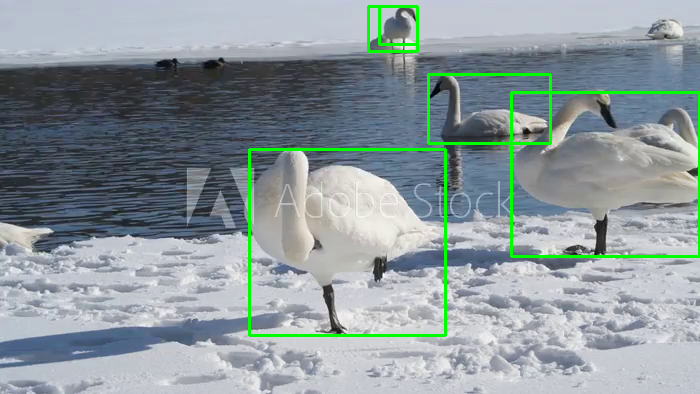

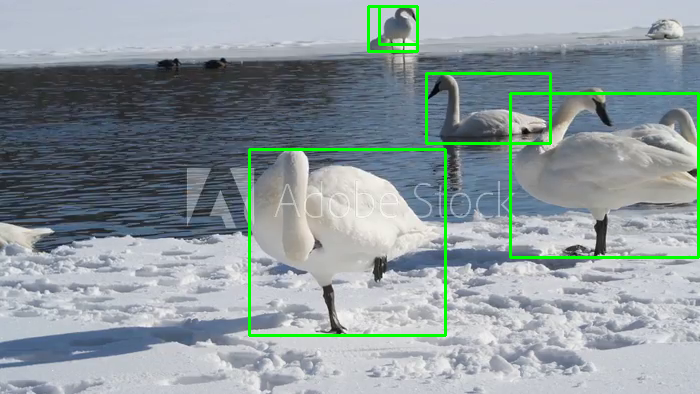

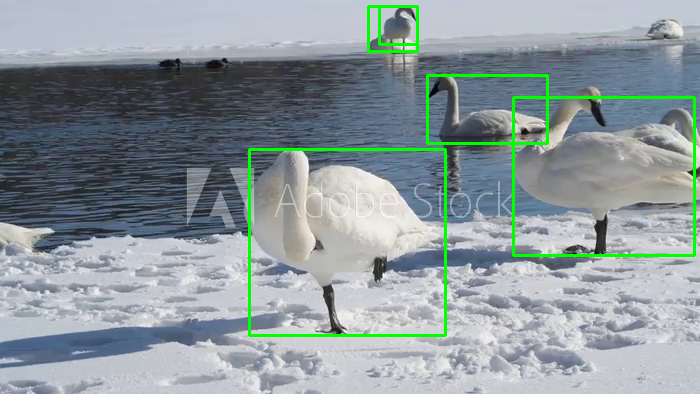

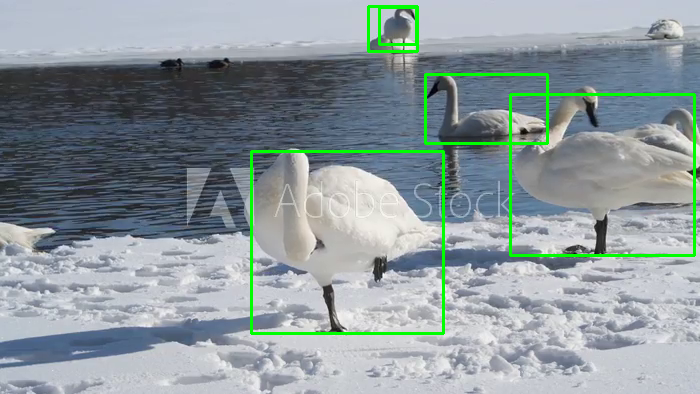

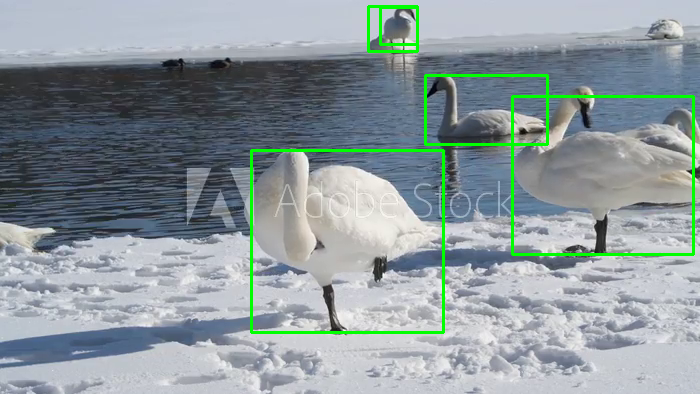

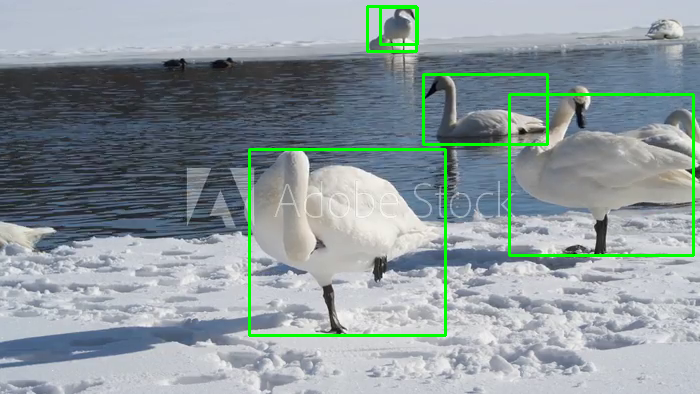

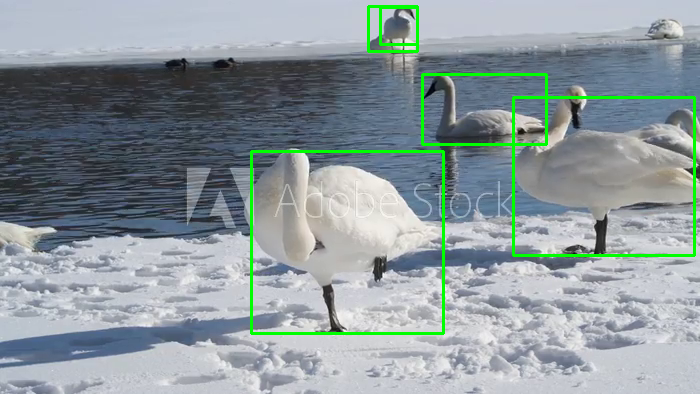

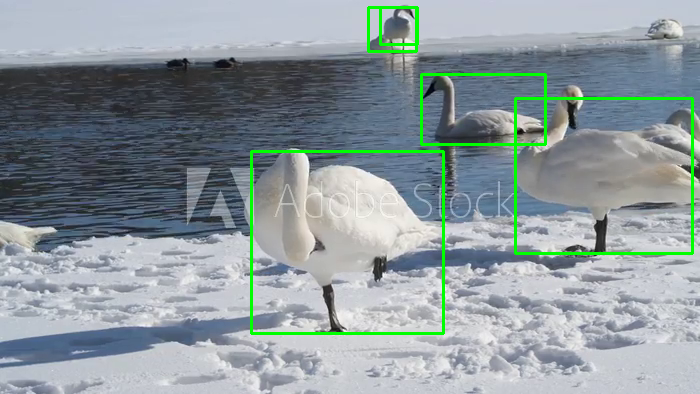

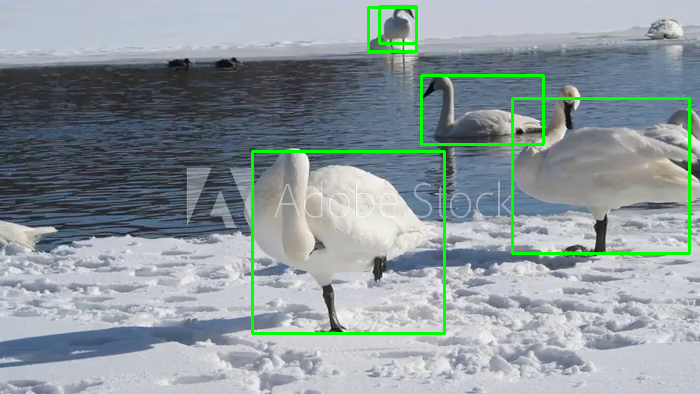

In [ ]:
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from google.colab import files
from ultralytics import YOLO

# Upload video manually
uploaded = files.upload()
video_path = list(uploaded.keys())[0]  # Get uploaded filename
cap = cv2.VideoCapture(video_path)

# Load YOLOv8 for object detection
model = YOLO("yolov8n.pt")  # Pre-trained model (smallest, fastest)

# Choose OpenCV tracker
tracker_type = 'CSRT'  # Options: 'KCF', 'MIL', 'MOSSE', 'BOOSTING'
if tracker_type == 'CSRT':
    tracker_constructor = cv2.legacy.TrackerCSRT_create
elif tracker_type == 'KCF':
    tracker_constructor = cv2.legacy.TrackerKCF_create
else:
    tracker_constructor = cv2.legacy.TrackerMOSSE_create

# Initialize MultiTracker
multi_tracker = cv2.legacy.MultiTracker()

# Read first frame
ret, frame = cap.read()
if not ret:
    print("Error: Couldn't read video frame")
    cap.release()
    exit()

# Run YOLOv8 detection on the first frame
results = model(frame)

# Extract bounding boxes from YOLO detection
bboxes = []
for result in results:
    for box in result.boxes.xyxy:
        x1, y1, x2, y2 = map(int, box)
        w, h = x2 - x1, y2 - y1
        bboxes.append((x1, y1, w, h))

# Add detected objects to OpenCV tracker
for bbox in bboxes:
    tracker = tracker_constructor()  # Create a new tracker instance
    multi_tracker.add(tracker, frame, bbox)

# Start tracking
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Update tracker
    success, boxes = multi_tracker.update(frame)

    # Draw bounding boxes
    for box in boxes:
        x, y, w, h = map(int, box)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display frame (Colab-friendly)
    cv2_imshow(frame)

# Release resources
cap.release()